In [105]:
import os
import sys

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.spatial import distance_matrix

import os
import urllib.request
import geopandas as gpd
from pandas import DataFrame
from dbfread import DBF

pd.set_option('display.max_columns', None)

# Geospatial data for Oil and Gas fields on the Norwegian Continental Shelf


## Table of Contents:

1. [Importing data](#Importing-and-preparing-data)
2. [Data analysis](#Data-analysis)
   1. [Fields](#Fields)
   2. [Pipes](#Pipes)
   3. [Rigs](#Rigs)
   4. [Wells](#Wells)
3. [Data manipulation](#Data-manipulation)
4. [Data visualization](#Data-visualization)


## Importing and preparing data

In this notebook, I will show how to import geolocation data and prepare it for further analysis. I will use the `geopandas` library to work with geolocation data and `folium` to visualize it. I will use the data to display the location of the different oil fields, wells and platforms on the Norwegian continental shelf.

Most of the data is from The open data at [Sokkeldirektoratet](https://www.sodir.no/om-oss/apne-data/).


In [3]:
# ----------------- Legacy code -----------------

# Import the data from the folder data/raw_data/geo


# geo_data_path = '../data/raw_data/geo/'
# 
# def import_data():
# 	fields = gpd.read_file(f'{geo_data_path}fields/fldArea.shp')
# 	pipes = gpd.read_file(f'{geo_data_path}pipes/pipLine.shp')
# 	rigs = gpd.read_file(f'{geo_data_path}rigs/fclPoint.shp')
# 	wells = gpd.read_file(f'{geo_data_path}well/wlbPoint.shp')
# 	return fields, pipes, rigs, wells
# 
# fields, pipes, rigs, wells = import_data()
# ----------------- Legacy code -----------------

In [102]:
# Define the URLs for the shapefile components
base_url = "https://github.com/percw/Norwegian_oil_gas_decarbonization/raw/main/data/raw_data/geo/"
shapefiles = {
    'fields': ['fields/fldArea.shp', 'fields/fldArea.shx', 'fields/fldArea.dbf'],
    'pipes': ['pipes/pipLine.shp', 'pipes/pipLine.shx', 'pipes/pipLine.dbf'],
    'rigs': ['rigs/fclPoint.shp', 'rigs/fclPoint.shx', 'rigs/fclPoint.dbf'],
    'wells': ['well/wlbPoint.shp', 'well/wlbPoint.shx', 'well/wlbPoint.dbf']
}

# Local directory to save downloaded files
local_dir = '../data/raw_data/geo/'

# Function to download a file from a URL to a local path
def download_file(url, local_path):
    urllib.request.urlretrieve(url, local_path)

# Download the shapefiles if they do not exist locally
for key, components in shapefiles.items():
    dir_path = os.path.join(local_dir, key)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        for component in components:
            local_path = os.path.join(dir_path, os.path.basename(component))
            download_file(base_url + component, local_path)
    else:
             print(f'{key} already exists')

# Function to read shapefiles into GeoPandas
def import_data():
    fields = gpd.read_file(os.path.join(local_dir, 'fields', 'fldArea.shp'))
    pipes = gpd.read_file(os.path.join(local_dir, 'pipes', 'pipLine.shp'))
    rigs = gpd.read_file(os.path.join(local_dir, 'rigs', 'fclPoint.shp'))
    wells = gpd.read_file(os.path.join(local_dir, 'well', 'wlbPoint.shp'))
    return fields, pipes, rigs, wells

fields, pipes, rigs, wells = import_data()

fields already exists
pipes already exists
rigs already exists
          fieldName curActStat discWelNam  discYear  \
0        ALBUSKJELL  Shut down      1/6-1      1972   
1  TOMMELITEN GAMMA  Shut down      1/9-4      1978   
2              VARG  Shut down    15/12-4      1984   
3     SLEIPNER VEST  Producing     15/6-3      1974   
4            GUNGNE  Producing    15/9-15      1982   

                  owner_kind          owner_name  idOwner  \
0         PRODUCTION LICENSE                 018    20900   
1  BUSINESS ARRANGEMENT AREA     TOMMELITEN UNIT    41411   
2                        NaN                 NaN        0   
3  BUSINESS ARRANGEMENT AREA  SLEIPNER VEST UNIT    40848   
4         PRODUCTION LICENSE                 046    21156   

                      OpLongName  idCompany fldSupBase          Dctype  \
0  ConocoPhillips Skandinavia AS    2410696        NaN  GAS/CONDENSATE   
1  ConocoPhillips Skandinavia AS    2410696        NaN  GAS/CONDENSATE   
2                

# Data Analysis


## Fields


In [103]:
display(fields)
display(fields.iloc[0])
display(fields['curActStat'].value_counts())
display(fields['Dctype'].value_counts())
display(fields['main_area'].value_counts())

fieldName               curActStat   discWelNam  discYear  \
0          ALBUSKJELL                Shut down        1/6-1      1972   
1    TOMMELITEN GAMMA                Shut down        1/9-4      1978   
2                VARG                Shut down      15/12-4      1984   
3       SLEIPNER VEST                Producing       15/6-3      1974   
4              GUNGNE                Producing      15/9-15      1982   
..                ...                      ...          ...       ...   
135              IRPA  Approved for production    6705/10-1      2009   
136         ALVE NORD  Approved for production  6607/12-2 S      2011   
137               ØRN  Approved for production   6507/2-5 S      2019   
138             EIRIN  Approved for production       15/5-2      1978   
139        HALTEN ØST  Approved for production    6507/11-6      2001   

                    owner_kind          owner_name   idOwner  \
0           PRODUCTION LICENSE                 018     20900   
1    BUSINESS ARRANGEMENT AREA     TOMMELITEN UNIT     41411   
2                          NaN                 NaN         0   
3    BUSINESS ARRANGEMENT AREA  SLEIPNER VEST UNIT     40848   
4           PRODUCTION LICENSE                 046     21156   
..                         ...                 ...       ...   
135         PRODUCTION LICENSE               327 B   4720054   
136         PRODUCTION LICENSE               127 C  29427330   
137         PRODUCTION LICENSE                 942  30676176   
138         PRODUCTION LICENSE               048 E  18450020   
139  BUSINESS ARRANGEMENT AREA     HALTEN ØST UNIT  38215610   

                        OpLongName  idCompany    fldSupBase          Dctype  \
0    ConocoPhillips Skandinavia AS    2410696           NaN  GAS/CONDENSATE   
1    ConocoPhillips Skandinavia AS    2410696           NaN  GAS/CONDENSATE   
2                              NaN          0      Tananger             OIL   
3                Equinor Energy AS   32011216       Dusavik  GAS/CONDENSATE   
4                Equinor Energy AS   32011216       Dusavik             GAS   
..                             ...        ...           ...             ...   
135              Equinor Energy AS   32011216           NaN             GAS   
136                    Aker BP ASA   28544099           NaN         OIL/GAS   
137                    Aker BP ASA   28544099           NaN             GAS   
138              Equinor Energy AS   32011216       Dusavik             GAS   
139              Equinor Energy AS   32011216  Kristiansund  GAS/CONDENSATE   

         main_area                                         discWelUrl  \
0        North sea  https://factpages.sodir.no/factpages/default.a...   
1        North sea  https://factpages.sodir.no/factpages/default.a...   
2        North sea  https://factpages.sodir.no/factpages/default.a...   
3        North sea  https://factpages.sodir.no/factpages/default.a...   
4        North sea  https://factpages.sodir.no/factpages/default.a...   
..             ...                                                ...   
135  Norwegian sea  https://factpages.sodir.no/factpages/default.a...   
136  Norwegian sea  https://factpages.sodir.no/factpages/default.a...   
137  Norwegian sea  https://factpages.sodir.no/factpages/default.a...   
138      North sea  https://factpages.sodir.no/factpages/default.a...   
139  Norwegian sea  https://factpages.sodir.no/factpages/default.a...   

                                                MapUrl  \
0    https://factmaps.sodir.no/factmaps/3_0/?run=Fi...   
1    https://factmaps.sodir.no/factmaps/3_0/?run=Fi...   
2    https://factmaps.sodir.no/factmaps/3_0/?run=Fi...   
3    https://factmaps.sodir.no/factmaps/3_0/?run=Fi...   
4    https://factmaps.sodir.no/factmaps/3_0/?run=Fi...   
..                                                 ...   
135  https://factmaps.sodir.no/factmaps/3_0/?run=Fi...   
136  https://factmaps.sodir.no/factmaps/3_0/?run=Fi...   
137  https://factm

fieldName                                            ALBUSKJELL
curActStat                                            Shut down
discWelNam                                                1/6-1
discYear                                                   1972
owner_kind                                   PRODUCTION LICENSE
owner_name                                                  018
idOwner                                                   20900
OpLongName                        ConocoPhillips Skandinavia AS
idCompany                                               2410696
fldSupBase                                                  NaN
Dctype                                           GAS/CONDENSATE
main_area                                             North sea
discWelUrl    https://factpages.sodir.no/factpages/default.a...
MapUrl        https://factmaps.sodir.no/factmaps/3_0/?run=Fi...
FactUrl       https://factpages.sodir.no/factpages/default.a...
idWellbore                              

Producing                  93
Shut down                  32
Approved for production    15
Name: curActStat, dtype: int64

OIL               64
OIL/GAS           29
GAS/CONDENSATE    28
GAS               18
OIL/CONDENSATE     1
Name: Dctype, dtype: int64

North sea        106
Norwegian sea     31
Barents sea        3
Name: main_area, dtype: int64

## Pipes


In [90]:
display(pipes)
display(pipes.iloc[0])
display(pipes['curPhase'].value_counts())


pipName  idPipeline  \
0                     36" Gas Disconnected, EKOFISK S      303866   
1                          34" Oil 36/22-BP, TEESSIDE      306280   
2                           34" Oil 37/4-BP, 36/22-BP      306314   
3                          42" Gas ÅSGARD ERB, KÅRSTØ      307674   
4                           20" Oil ULA PP, EKOFISK J      308524   
..                                                ...         ...   
74                36" Oil JOHAN SVERDRUP RP, MONGSTAD      456564   
75  18" Gas JOHAN SVERDRUP RP, JOHAN SVERDRUP STAT...      456695   
76  12" Gas JOHAN SVERDRUP STATPIPE PLEM, JOHAN SV...      456933   
77   12.75" Injection ØYGARDEN ENERGIPARK, 31/5-7 EOS      762593   
78                   10.75" Oil GINA KROG, SLEIPNER A      763747   

                  mapLabel              belongs_to  \
0                 Statpipe                STATPIPE   
1      Norpipe Oljeledning     NORPIPE OLJELEDNING   
2      Norpipe Oljeledning     NORPIPE OLJELEDNING   
3         Åsgard Transport                 GASSLED   
4              Ula Oljerør             ULA OLJERØR   
..                     ...                     ...   
74  Johan Sverdrup Oljerør          JOHAN SVERDRUP   
75  Johan Sverdrup Gassrør          JOHAN SVERDRUP   
76                     NaN  JOHAN SVERDRUP GASSRØR   
77                     NaN                     NaN   
78                     NaN               GINA KROG   

                       curOperNam        curPhase   curPhDate  \
0                       Gassco AS  DECOMMISSIONED  1998-08-01   
1   ConocoPhillips Skandinavia AS      IN SERVICE  1975-10-14   
2   ConocoPhillips Skandinavia AS      IN SERVICE  1975-10-14   
3                       Gassco AS      IN SERVICE  2000-10-04   
4                     Aker BP ASA      IN SERVICE  1986-05-01   
..                            ...             ...         ...   
74              Equinor Energy AS      IN SERVICE  2019-10-05   
75              Equinor Energy AS      IN SERVICE  2019-10-05   
76              Equinor Energy AS      IN SERVICE  2019-10-05   
77                     ingen oper    INSTALLATION  2023-03-15   
78              Equinor Energy AS    INSTALLATION  2023-05-31   

                      fromFacili                       toFacility  \
0                            NaN                        EKOFISK S   
1                       36/22-BP                         TEESSIDE   
2                        37/4-BP                         36/22-BP   
3                     ÅSGARD ERB                           KÅRSTØ   
4                         ULA PP                        EKOFISK J   
..                           ...                              ...   
74             JOHAN SVERDRUP RP                         MONGSTAD   
75             JOHAN SVERDRUP RP     JOHAN SVERDRUP STATPIPE PLEM   
76  JOHAN SVERDRUP STATPIPE PLEM  JOHAN SVERDRUP STATPIPE HOT TAP   
77           ØYGARDEN ENERGIPARK                       31/5-7 EOS   
78                     GINA KROG                       SLEIPNER A   

           mainGrp  ...  WaterDepth     medium idBelongTo  idFrmFacil  \
0   Transportation  ...        80.0        Gas     123940           0   
1   Transportation  ...        95.0        Oil     124133      286673   
2   Transportation  ...        95.0        Oil     124133      286645   
3   Transportation  ...       372.0        Gas    2252643      282613   
4   Transportation  ...        75.0        Oil     124285      272029   
..             ...  ...         ...        ...        ...         ...   
74  Transportation  ...       580.0        Oil   26376286      449981   
75  Transportation  ...       280.0        Gas   26376286      449981   
76  Transportation  ...         0.0        Gas   23867727      456808   
77  Transportation  ...       575.0  Injection          0      762250   
78  Transportation  ...       116.0        Oil   23384544      443856   

    idToFacili  idOperator   dtUpdated  \
0       271973     1944954  2024-01-02 

pipName                         36" Gas Disconnected, EKOFISK S
idPipeline                                               303866
mapLabel                                               Statpipe
belongs_to                                             STATPIPE
curOperNam                                            Gassco AS
curPhase                                         DECOMMISSIONED
curPhDate                                            1998-08-01
fromFacili                                                  NaN
toFacility                                            EKOFISK S
mainGrp                                          Transportation
dimension                                                  36.0
WaterDepth                                                 80.0
medium                                                      Gas
idBelongTo                                               123940
idFrmFacil                                                    0
idToFacili                              

IN SERVICE            66
DECOMMISSIONED         9
ABANDONED IN PLACE     2
INSTALLATION           2
Name: curPhase, dtype: int64

## Rigs


In [112]:
display(rigs)
display(rigs.iloc[0])
display(rigs['phaseName'].value_counts())
display(rigs['nationName'].value_counts())
display(rigs['surface'].value_counts())


idFacility  idOperator  idCompResp    FixMov        facName  \
0         271245    32011216           0     FIXED      OSEBERG A   
1         271273    32011216           0     FIXED    STATFJORD A   
2         271301    32011216           0     FIXED    STATFJORD B   
3         271329    32011216           0     FIXED    STATFJORD C   
4         271357     2410696           0     FIXED   ALBUSKJELL A   
...          ...         ...         ...       ...            ...   
1160      775404           0           0  MOVEABLE  SIEM STINGRAY   
1161      775702           0           0  MOVEABLE  NORMAND OCEAN   
1162      776827    28544099           0     FIXED         FENRIS   
1163      777168    28544099           0     FIXED    VALHALL PWP   
1164      777657           0           0  MOVEABLE   SKANDI FLORA   

               facKind    phaseName  \
0     CONDEEP 4 SHAFTS   IN SERVICE   
1     CONDEEP 3 SHAFTS   IN SERVICE   
2     CONDEEP 4 SHAFTS   IN SERVICE   
3     CONDEEP 4 SHAFTS   IN SERVICE   
4       JACKET 12 LEGS      REMOVED   
...                ...          ...   
1160            VESSEL   IN SERVICE   
1161            VESSEL   IN SERVICE   
1162     JACKET 4 LEGS  FABRICATION   
1163     JACKET 8 LEGS  FABRICATION   
1164            VESSEL   IN SERVICE   

                                        facFunc datum  ns_deg  ns_min  \
0               DRILLING - PROCESSING - QUARTER  ED50      60      29   
1     DRILLING - PROCESSING - QUARTER - STORAGE  ED50      61      15   
2     DRILLING - PROCESSING - QUARTER - STORAGE  ED50      61      12   
3     DRILLING - PROCESSING - QUARTER - STORAGE  ED50      61      17   
4                                           NaN  ED50      56      38   
...                                         ...   ...     ...     ...   
1160                                        NaN   NaN       0       0   
1161                                        NaN   NaN       0       0   
1162                                   WELLHEAD  ED50      56      42   
1163                      DRILLING - PROCESSING  ED50      56      16   
1164                                        NaN   NaN       0       0   

      ns_second ns_code  ew_deg  ew_min  ew_second ew_code  utmHemis  \
0         30.71       N       2      49      38.33       E         1   
1         20.46       N       1      51      13.95       E         1   
2         24.88       N       1      49      50.29       E         1   
3         47.70       N       1      54       9.17       E         1   
4         34.39       N       2      56      24.03       E         1   
...         ...     ...     ...     ...        ...     ...       ...   
1160        NaN       N       0       0        NaN       E         0   
1161        NaN       N       0       0        NaN       E         0   
1162       0.01       N       3       7       8.38       E         1   
1163      31.13       N       3      23      57.64       E         1   
1164        NaN       N       0       0        NaN       E         0   

      utm_zone      ns_utm     ew_utm   rkb  WaterDepth   dtStartup  lifetime  \
0           31  6706361.32  490510.84   0.0       109.0  1988-12-01        40   
1           31  6791967.89  438508.87  64.4       145.0  1979-11-24        30   
2           31  6786557.69  437164.96  77.8       145.0  1982-11-05        30   
3           31  6796478.63  441196.55  78.4       145.0  1985-06-26        30   
4           31  6277776.33  496320.62  41.0        71.0  1979-05-01        20   
...        ...         ...        ...   ...         ...         ...       ...   
1160         0         NaN        NaN   0.0         0.0         NaN         0   
1161         0         NaN        NaN   0.0         0.0         NaN         0   
1162        31  6284138.93  507287.08   0.0        68.0         NaN        30   
1163        31  6236931.99  524730.00   0.0        76.0         NaN        30   
1164         0         NaN        NaN   0.0         0.0         NaN        

idFacility                                               271245
idOperator                                             32011216
idCompResp                                                    0
FixMov                                                    FIXED
facName                                               OSEBERG A
facKind                                        CONDEEP 4 SHAFTS
phaseName                                            IN SERVICE
facFunc                         DRILLING - PROCESSING - QUARTER
datum                                                      ED50
ns_deg                                                       60
ns_min                                                       29
ns_second                                                 30.71
ns_code                                                       N
ew_deg                                                        2
ew_min                                                       49
ew_second                               

IN SERVICE            825
REMOVED                79
INSTALLATION           58
SHUT DOWN              51
LAID UP                22
FUTURE                 18
DECOMMISSIONED         18
PARTLY REMOVED          6
FABRICATION             6
DISPOSAL COMPLETED      2
ABANDONED IN PLACE      1
Name: phaseName, dtype: int64

Norway                1003
United Kingdom          37
Panama                  33
Bahamas                 20
Denmark                 12
Singapore                8
Liberia                  7
Marshall Islands         7
Italy                    6
Germany                  5
France                   4
Netherlands              4
Bermuda                  4
Belgium                  3
Cyprus                   2
China                    1
Austria                  1
Poland                   1
Cayman Islands           1
United States            1
Spain                    1
Finland                  1
Luxembourg               1
Russian Federation       1
Isle of Man              1
Name: nationName, dtype: int64

N    638
Y    527
Name: surface, dtype: int64

## Wells


In [104]:
display(wells)
print(wells.iloc[0])
display(wells['purpose'].value_counts())
display(wells['well_type'].value_counts())
display(wells.iloc[0]['FactUrl'])



wbName  idWellbore   well_name                        drilOperat  \
0            1/3-4           2       1/3-4            Elf Petroleum Norge AS   
1            2/2-3           3       2/2-3                Saga Petroleum ASA   
2          30/6-12           4     30/6-12         Norsk Hydro Produksjon AS   
3         34/10-17           5    34/10-17  Den norske stats oljeselskap a.s   
4          31/2-11           6     31/2-11                  A/S Norske Shell   
...            ...         ...         ...                               ...   
9285   31/4-A-28 D       10099   31/4-A-28                          OKEA ASA   
9286   30/9-B-48 A       10100   30/9-B-48                 Equinor Energy AS   
9287  33/12-B-15 D       10101  33/12-B-15                 Equinor Energy AS   
9288      36/7-5 B       10102      36/7-5               Vår Energi Norge AS   
9289  34/10-D-4 AH       10103   34/10-D-4                 Equinor Energy AS   

                                              DrlFacURL  idCompany prodLicenc  \
0     https://factpages.sodir.no/factpages/default.a...        298        065   
1     https://factpages.sodir.no/factpages/default.a...        716        066   
2     https://factpages.sodir.no/factpages/default.a...        430        053   
3     https://factpages.sodir.no/factpages/default.a...        749        050   
4     https://factpages.sodir.no/factpages/default.a...        562        054   
...                                                 ...        ...        ...   
9285  https://factpages.sodir.no/factpages/default.a...   34925006        055   
9286  https://factpages.sodir.no/factpages/default.a...   32011216        079   
9287  https://factpages.sodir.no/factpages/default.a...   32011216        037   
9288  https://factpages.sodir.no/factpages/default.a...   50000114        636   
9289  https://factpages.sodir.no/factpages/default.a...   32011216        050   

         purpose  status         content  ... wPalySlide dtPlugged wWBhist  \
0        WILDCAT     P&A       OIL SHOWS  ...          F       NaN       T   
1        WILDCAT     P&A             DRY  ...          T       NaN       T   
2      APPRAISAL  JUNKED  NOT APPLICABLE  ...          F       NaN       T   
3        WILDCAT     P&A         OIL/GAS  ...          T       NaN       T   
4      APPRAISAL     P&A         OIL/GAS  ...          F       NaN       T   
...          ...     ...             ...  ...        ...       ...     ...   
9285  PRODUCTION     NaN             NaN  ...          F       NaN       F   
9286  PRODUCTION     NaN             NaN  ...          F       NaN       F   
9287  PRODUCTION     NaN             NaN  ...          F       NaN       F   
9288   APPRAISAL     NaN             NaN  ...          F       NaN       F   
9289  PRODUCTION     NaN             NaN  ...          F       NaN       F   

     plTarget dtPlgdAbnd idSiteSurv SiteSurvey    dtUpdMax   dtUpdated  \
0         NaN        NaN          0        NaN  2024-01-02  2024-01-02   
1         NaN        NaN          0        NaN  2024-01-02  2024-01-02   
2         NaN        NaN          0        NaN  2024-01-02  2024-01-02   
3         NaN        NaN          0        NaN  2024-01-02  2024-01-02   
4         NaN        NaN          0        NaN  2024-01-02  2024-01-02   
...       ...        ...        ...        ...         ...         ...   
9285      NaN        NaN          0        NaN         NaN  2024-05-08   
9286      NaN        NaN          0        NaN         NaN  2024-05-10   
9287      NaN        NaN          0        NaN         NaN  2024-05-11   
9288      NaN        NaN          0        NaN         NaN  2024-05-14   
9289      NaN        NaN          0        NaN         NaN  2024-05-16   

                      geometry  
0     POINT (2.71673 56.94423)  
1     POINT (3.42726 56.79345)  
2     POINT (2.82314 60.55433)  
3     POINT (2.01411 61.06637)  
4     POINT (3.42504 60.82438)  
...                        ...  
9285  POINT (3.04751 

wbName                                                    1/3-4
idWellbore                                                    2
well_name                                                 1/3-4
drilOperat                               Elf Petroleum Norge AS
DrlFacURL     https://factpages.sodir.no/factpages/default.a...
                                    ...                        
idSiteSurv                                                    0
SiteSurvey                                                  NaN
dtUpdMax                                             2024-01-02
dtUpdated                                            2024-01-02
geometry                             POINT (2.716731 56.944225)
Name: 0, Length: 126, dtype: object


PRODUCTION       4326
WILDCAT          1359
INJECTION         887
APPRAISAL         749
SOIL DRILLING     657
OBSERVATION       652
SHALLOW GAS       206
SCIENTIFIC        171
UNKNOWN            91
STRATIGRAPHIC      30
PILOT              24
NOT AVAILABLE       3
INJECTION-CCS       2
WILDCAT-CCS         1
Name: purpose, dtype: int64

DEVELOPMENT    5885
EXPLORATION    2104
OTHER          1300
Name: well_type, dtype: int64

'https://factpages.sodir.no/factpages/default.aspx?nav1=wellbore&nav2=PageView|Exploration|All&nav3=2'

In [29]:
# Loop through entire list and check the different values in the curActStat column
fields['curActStat'].value_counts()


Producing                  93
Shut down                  32
Approved for production    15
Name: curActStat, dtype: int64

## Extracting all the producing data


In [53]:
# Producing fields, pipes, rigs and wells

# Fields
producing_fields = fields[fields['curActStat'] == 'Producing']
approved_fields = fields[fields['curActStat'] == 'Approved for production']

#Pipes
producing_pipes = pipes[pipes['curPhase'] == 'IN SERVICE']

# Rigs
producing_rigs = rigs[rigs['phaseName'] == 'IN SERVICE']

# Wells
producing_wells = wells[wells['purpose'] == 'PRODUCTION']


In [54]:
approved_fields

fieldName               curActStat    discWelNam  discYear  \
119  JOHAN CASTBERG  Approved for production      7220/8-1      2011   
126         TYRVING  Approved for production        25/4-2      1973   
127         BERLING  Approved for production    6506/11-10      2018   
128           HUGIN  Approved for production     25/2-10 S      1986   
129           MUNIN  Approved for production     30/11-8 S      2011   
130       IDUN NORD  Approved for production      6507/3-7      2009   
131          FENRIS  Approved for production        2/4-21      2012   
132           FULLA  Approved for production       30/11-7      2009   
133           SYMRA  Approved for production     16/1-29 S      2018   
134        VERDANDE  Approved for production  6608/10-17 S      2017   
135            IRPA  Approved for production     6705/10-1      2009   
136       ALVE NORD  Approved for production   6607/12-2 S      2011   
137             ØRN  Approved for production    6507/2-5 S      2019   
138           EIRIN  Approved for production        15/5-2      1978   
139      HALTEN ØST  Approved for production     6507/11-6      2001   

                    owner_kind       owner_name   idOwner         OpLongName  \
119         PRODUCTION LICENSE              532   5463659  Equinor Energy AS   
126  BUSINESS ARRANGEMENT AREA     TYRVING UNIT  40662362        Aker BP ASA   
127         PRODUCTION LICENSE            644 B  27434494     OMV (Norge) AS   
128         PRODUCTION LICENSE              442   4237510        Aker BP ASA   
129         PRODUCTION LICENSE              035     21068        Aker BP ASA   
130         PRODUCTION LICENSE            159 D   4939421        Aker BP ASA   
131         PRODUCTION LICENSE              146     21980        Aker BP ASA   
132         PRODUCTION LICENSE              873  28973585        Aker BP ASA   
133         PRODUCTION LICENSE              167     22148        Aker BP ASA   
134  BUSINESS ARRANGEMENT AREA    VERDANDE UNIT  41319878  Equinor Energy AS   
135         PRODUCTION LICENSE            327 B   4720054  Equinor Energy AS   
136         PRODUCTION LICENSE            127 C  29427330        Aker BP ASA   
137         PRODUCTION LICENSE              942  30676176        Aker BP ASA   
138         PRODUCTION LICENSE            048 E  18450020  Equinor Energy AS   
139  BUSINESS ARRANGEMENT AREA  HALTEN ØST UNIT  38215610  Equinor Energy AS   

     idCompany    fldSupBase          Dctype      main_area  \
119   32011216    Hammerfest         OIL/GAS    Barents sea   
126   28544099           NaN             OIL      North sea   
127    4460594  Kristiansund  GAS/CONDENSATE  Norwegian sea   
128   28544099           NaN         OIL/GAS      North sea   
129   28544099           NaN         OIL/GAS      North sea   
130   28544099           NaN             GAS  Norwegian sea   
131   28544099      Tananger  GAS/CONDENSATE      North sea   
132   28544099           NaN  OIL/CONDENSATE      North sea   
133   28544099           NaN         OIL/GAS      North sea   
134   32011216           NaN         OIL/GAS  Norwegian sea   
135   32011216           NaN             GAS  Norwegian sea   
136   28544099           NaN         OIL/GAS  Norwegian sea   
137   28544099           NaN             GAS  Norwegian sea   
138   32011216       Dusavik             GAS      North sea   
139   32011216  Kristiansund  GAS/CONDENSATE  Norwegian sea   

                                            discWelUrl  \
119  https://factpages.sodir.no/factpages/default.a...   
126  https://factpages.sodir.no/factpages/default.a...   
127  https://factpages.sodir.no/factpages/default.a...   
128  https://factpages.sodir.no/factpages/default.a...   
129  https://factpages.sodir.no/factpages/default.a...   
130  https://factpages.sodir.no/factpages/default.a...   
131  https://factpages.sodir.no/factpages/default.a...   
132  https://factpages.sodir.no/factpages/default.a...   
133  https://factpages.sodir.no/factpages/def

In [109]:

from shapely.geometry import Point

# Get the centroid of the producing fields to center the map
centroid = producing_fields.geometry.centroid.unary_union.centroid

# Create a folium map centered at the centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=6, tiles='OpenStreetMap')

# Function to add GeoDataFrame to folium map with specified color
def add_gdf_to_folium(gdf, name, map_obj, color, weight=1):
    folium.GeoJson(
        gdf,
        name=name,
        style_function=lambda x: {'color': color, 'weight': weight, 'fillColor': color, 'fillOpacity': 0.2},
    ).add_to(map_obj)

def add_point_to_folium(gdf, name, map_obj, color, radius=5):
    for idx, row in gdf.iterrows():
        if isinstance(row.geometry, Point) and not row.geometry.is_empty:
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=radius,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=1.0
            ).add_to(map_obj)

# Add the producing fields to the folium map with light purple color
add_gdf_to_folium(producing_fields, 'Producing Fields', m, 'purple')

# Add the approved fields to the folium map with light red color
add_gdf_to_folium(approved_fields, 'Approved Fields', m, 'red')

# Add the pipes to the folium map with light blue color
add_gdf_to_folium(producing_pipes, 'Pipes', m, 'black', weight=0.2)

# Add the rigs to the folium map
add_point_to_folium(producing_rigs, 'Rigs', m, 'orange', radius=0.2)

# Add the wells to the folium map
add_point_to_folium(producing_wells, 'Wells', m, 'lightgreen', radius=0.2)

# Adding a title to the map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Oil and Gas Fields, Rigs, Pipes and Wells in Norway</b></h3>
             '''

m.get_root().html.add_child(folium.Element(title_html))

# Add a legend
legend_html = '''
    <div style="position: fixed; 
                 top: 55px; left: 50px; width: 150px; height: 125px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
                 ">&nbsp; Data points <br>
                 &nbsp; Producing Fields &nbsp; <i class="fa fa-square" style="color:purple"></i><br>
                 &nbsp; Approved Fields &nbsp; <i class="fa fa-square" style="color:red"></i><br>
                 &nbsp; Pipes &nbsp; <i class="fa fa-minus" style="color:black"></i><br>
                 &nbsp; Rigs &nbsp; <i class="fa fa-circle" style="color:orange"></i><br>
                 &nbsp; Wells &nbsp; <i class="fa fa-circle" style="color:lightgreen"></i>
    </div>
    '''
m.get_root().html.add_child(folium.Element(legend_html))
# Add layer control
folium.LayerControl().add_to(m)

# Display the map in the Jupyter Notebook
display(m)

/var/folders/bq/x4f4q_6s4sz988ksbbmgknk00000gn/T/ipykernel_55993/264651817.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = producing_fields.geometry.centroid.unary_union.centroid


In [85]:
# Number of producing fields:
print(f'Number of producing fields: {len(producing_fields)}')

# Number of producing pipes:
print(f'Number of producing pipes: {len(producing_pipes)}')

# Number of producing rigs:
print(f'Number of producing rigs: {len(producing_rigs)}')

# Number of producing wells:
print(f'Number of producing wells: {len(producing_wells)}')

# Calculate the total area of the producing fields in square kilometers
total_area = producing_fields.geometry.to_crs(epsg=32633).area.sum() / 10**6
print(f'Total area of producing fields: {total_area:.2f} km^2')

# Calculate the total length of the producing pipes in kilometers
total_length = producing_pipes.geometry.to_crs(epsg=32633).length.sum() / 10**3
print(f'Total length of producing pipes: {total_length:.2f} km')

# Calculate the average distance between the producing rigs in kilometers
# Extract the coordinates of the producing rigs with geometry attribute set
rig_coords = np.array([[point.x, point.y] for point in producing_rigs.geometry if not point.is_empty])
rig_distances = distance_matrix(rig_coords, rig_coords)
average_distance = np.mean(rig_distances[np.triu_indices(len(rig_distances), k=1)]) / 10**3
print(f'Average distance between producing rigs: {average_distance:.2f} km')


Number of producing fields: 93
Number of producing pipes: 66
Number of producing rigs: 825
Number of producing wells: 4326
Total area of producing fields: 4960.94 km^2
Total length of producing pipes: 11520.72 km
Average distance between producing rigs: 0.01 km


In [70]:
import folium
from folium.plugins import HeatMap

# Get the centroid of the producing fields to center the map
centroid = producing_fields.geometry.centroid.unary_union.centroid

# Create a folium map centered at the centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=6, tiles='OpenStreetMap')

# Extract coordinates for the producing rigs, excluding empty geometries
rigs_coords = [[point.y, point.x] for point in producing_rigs.geometry if not point.is_empty]

# Add heatmap for producing rigs
HeatMap(rigs_coords).add_to(m)

# Display the map in the Jupyter Notebook
display(m)

/var/folders/bq/x4f4q_6s4sz988ksbbmgknk00000gn/T/ipykernel_55993/3400216215.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = producing_fields.geometry.centroid.unary_union.centroid


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


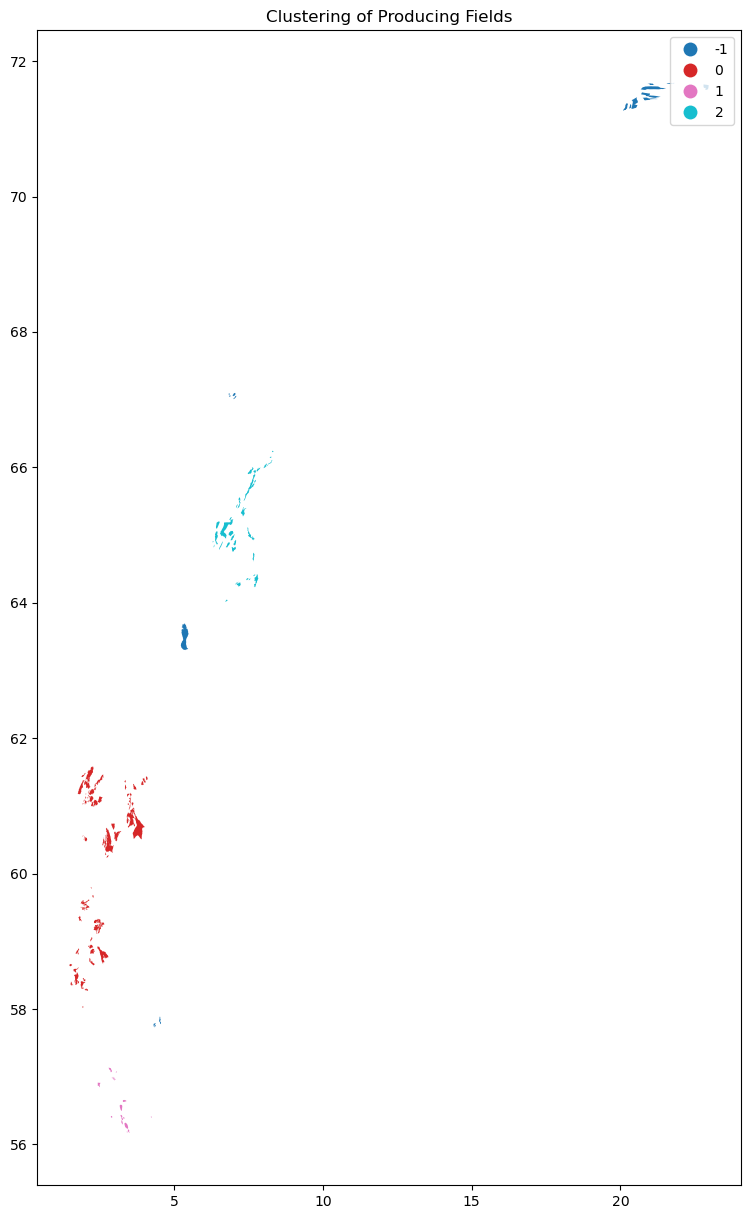

In [77]:
from sklearn.cluster import DBSCAN
import numpy as np

# Extract coordinates for the producing fields
fields_coords = np.array([[point.centroid.y, point.centroid.x] for point in producing_fields.geometry])

# Perform DBSCAN clustering
db = DBSCAN(eps=1, min_samples=5).fit(fields_coords)
labels = db.labels_

# Add clusters to the GeoDataFrame
producing_fields['cluster'] = labels

# Plot clusters
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
producing_fields.plot(column='cluster', categorical=True, legend=True, ax=ax)
ax.set_title('Clustering of Producing Fields')
plt.show()

/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


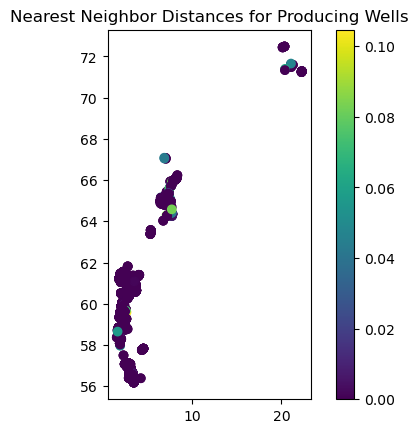

In [69]:
# Calculate distance matrix for the producing wells
coords = np.array([[point.y, point.x] for point in producing_wells.geometry])
dist_matrix = distance_matrix(coords, coords)

# Get the nearest neighbor distance for each well
nearest_distances = np.sort(dist_matrix, axis=1)[:, 1]

# Add nearest neighbor distance to the GeoDataFrame
producing_wells['nearest_dist'] = nearest_distances

# Plot the distribution of nearest neighbor distances
producing_wells.plot(column='nearest_dist', cmap='viridis', legend=True)
plt.title('Nearest Neighbor Distances for Producing Wells')
plt.show()